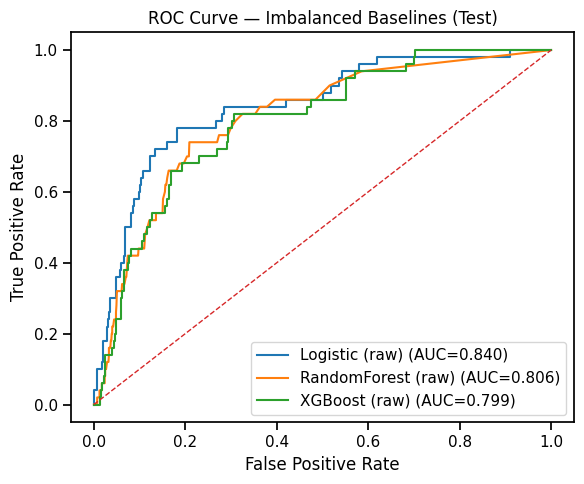

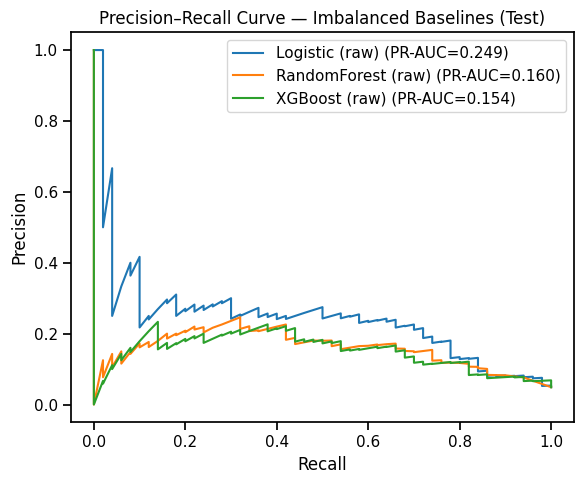

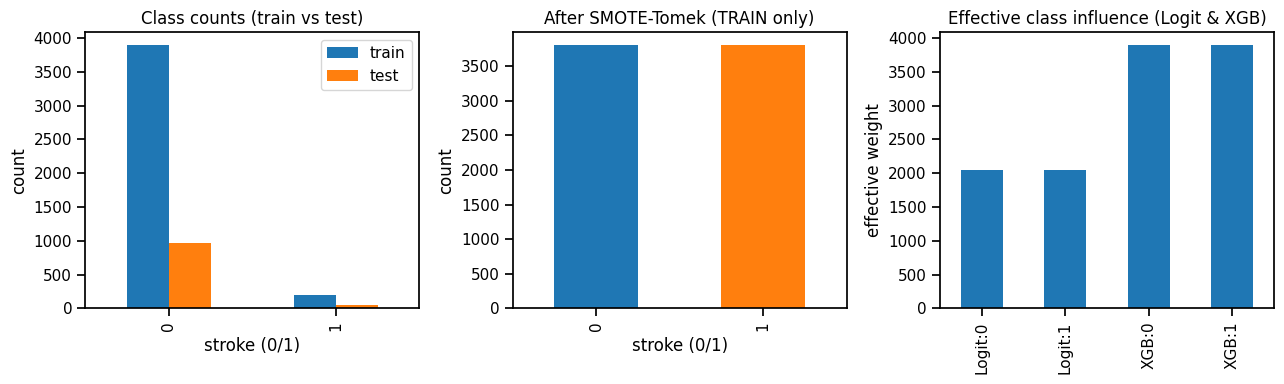

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best XGB (CV ROC-AUC): 0.8391
Best params: {'clf__subsample': 1.0, 'clf__reg_lambda': 2.0, 'clf__n_estimators': 500, 'clf__max_depth': 3, 'clf__learning_rate': 0.01, 'clf__gamma': 1.0, 'clf__colsample_bytree': 1.0}

== Logistic (balanced) ==
ROC-AUC: 0.8400 | PR-AUC: 0.2501 | Best F2 thr: 0.727 (F2=0.496, P=0.229, R=0.700)

Logistic (balanced) — Classification report @ thr=0.50
              precision    recall  f1-score   support

           0      0.985     0.743     0.847       972
           1      0.135     0.780     0.230        50

    accuracy                          0.745      1022
   macro avg      0.560     0.761     0.539      1022
weighted avg      0.943     0.745     0.817      1022



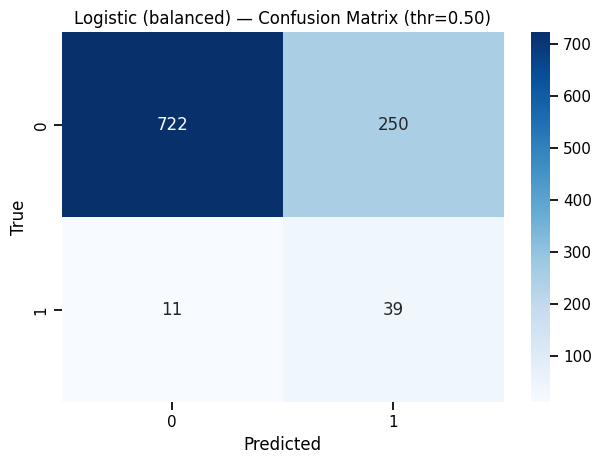


Logistic (balanced) — Classification report @ thr=0.73
              precision    recall  f1-score   support

           0      0.983     0.879     0.928       972
           1      0.229     0.700     0.345        50

    accuracy                          0.870      1022
   macro avg      0.606     0.789     0.636      1022
weighted avg      0.946     0.870     0.899      1022



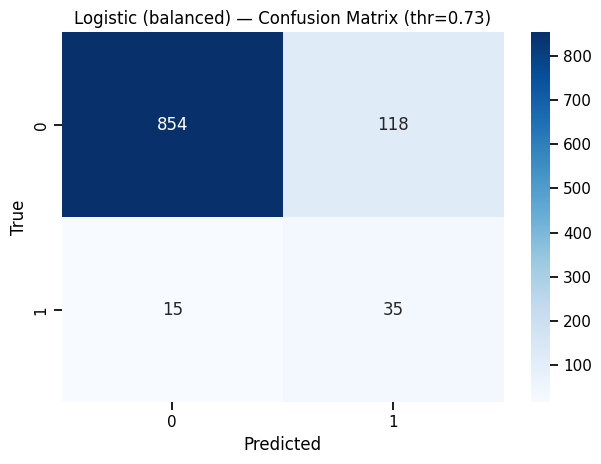


== RandomForest + SMOTETomek ==
ROC-AUC: 0.8123 | PR-AUC: 0.1607 | Best F2 thr: 0.176 (F2=0.413, P=0.139, R=0.820)

RandomForest + SMOTETomek — Classification report @ thr=0.50
              precision    recall  f1-score   support

           0      0.968     0.915     0.941       972
           1      0.202     0.420     0.273        50

    accuracy                          0.890      1022
   macro avg      0.585     0.667     0.607      1022
weighted avg      0.931     0.890     0.908      1022



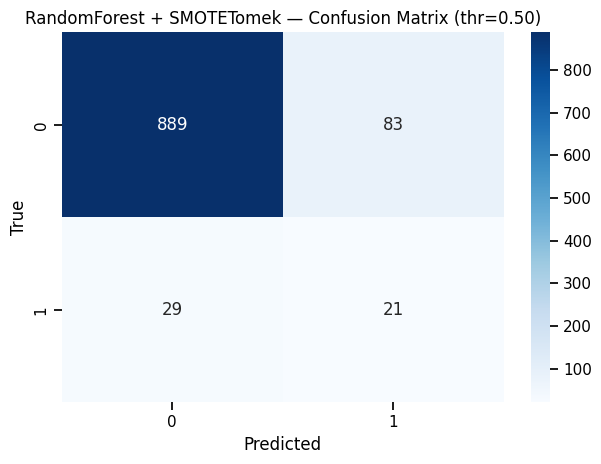


RandomForest + SMOTETomek — Classification report @ thr=0.18
              precision    recall  f1-score   support

           0      0.988     0.738     0.845       972
           1      0.139     0.820     0.237        50

    accuracy                          0.742      1022
   macro avg      0.563     0.779     0.541      1022
weighted avg      0.946     0.742     0.815      1022



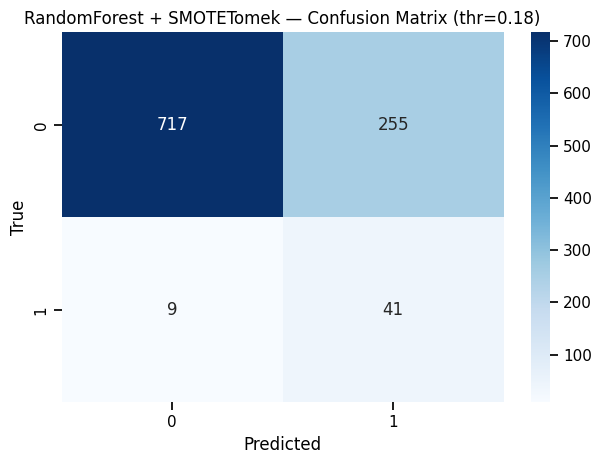


== XGBoost (tuned + calibrated) ==
ROC-AUC: 0.8337 | PR-AUC: 0.2284 | Best F2 thr: 0.119 (F2=0.480, P=0.229, R=0.660)

XGBoost (tuned + calibrated) — Classification report @ thr=0.50
              precision    recall  f1-score   support

           0      0.951     1.000     0.975       972
           1      0.000     0.000     0.000        50

    accuracy                          0.951      1022
   macro avg      0.476     0.500     0.487      1022
weighted avg      0.905     0.951     0.927      1022



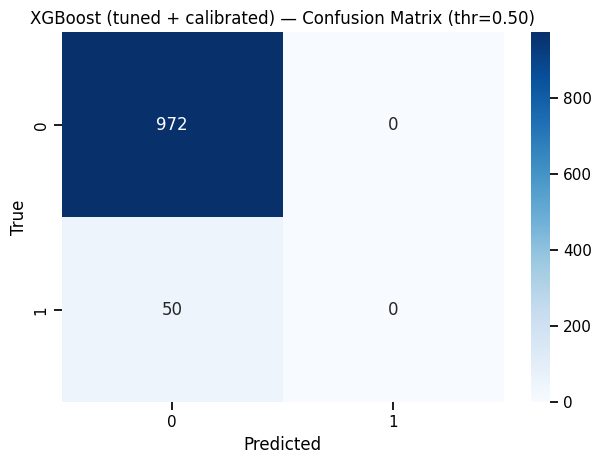


XGBoost (tuned + calibrated) — Classification report @ thr=0.12
              precision    recall  f1-score   support

           0      0.981     0.886     0.931       972
           1      0.229     0.660     0.340        50

    accuracy                          0.875      1022
   macro avg      0.605     0.773     0.636      1022
weighted avg      0.944     0.875     0.902      1022



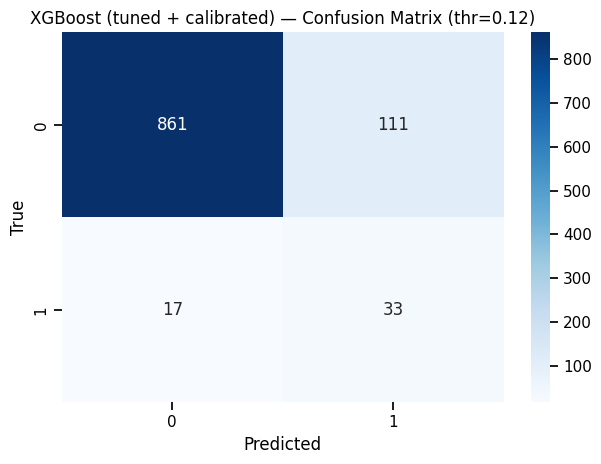


=== Balanced Models (Test) ===
                     ROC-AUC  PR-AUC
Logistic (balanced)    0.840   0.250
RF + SMOTETomek        0.812   0.161
XGB (tuned+cal)        0.834   0.228


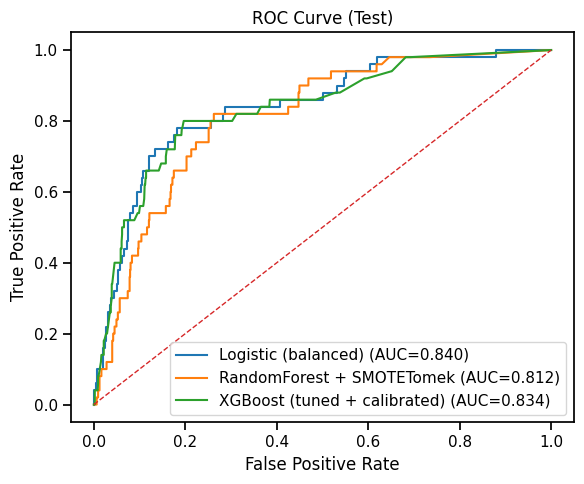

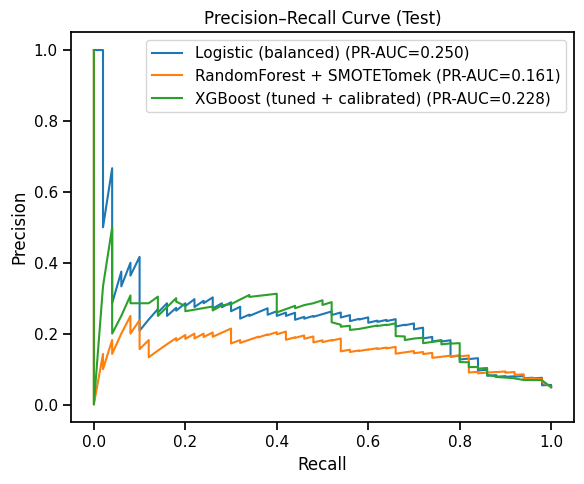

In [1]:
import warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve,
                             recall_score, fbeta_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import clone

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
sns.set_context("notebook")

# ----------------------------
# 0) Load cleaned data
# ----------------------------
DATA_PATH = Path("../data/stroke_clean.csv")
df = pd.read_csv(DATA_PATH)
df["stroke"] = df["stroke"].astype(int)

# ----------------------------
# 1) Select medically relevant features + simple interactions
# ----------------------------
selected_feats = ["age","hypertension","heart_disease","avg_glucose_level","bmi","smoking_status"]
target = "stroke"
df = df[selected_feats + [target]].copy()

df["age_bmi_interaction"] = df["age"] * df["bmi"]
df["age_glucose_ratio"]   = df["avg_glucose_level"] / (df["age"] + 1)

df["smoking_status"] = df["smoking_status"].astype(str).str.lower().fillna("unknown")
df["smoking_known"]  = (df["smoking_status"] != "unknown").astype(int)

num_features = ["age","avg_glucose_level","bmi","age_bmi_interaction","age_glucose_ratio"]
cat_features = ["smoking_status","smoking_known"]

X = df[num_features + cat_features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ----------------------------
# 2) Preprocessing (define BEFORE any use)
# ----------------------------
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler",  StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("ohe",     OneHotEncoder(handle_unknown="ignore"))])
preprocess = ColumnTransformer([("num", num_pipe, num_features),
                                ("cat", cat_pipe, cat_features)])

# ----------------------------

# ================================
# ROC & PR Curves — Imbalanced Baselines (no balancing)
# ================================
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

# 1) Define + fit imbalanced baseline models (preprocessing only)
baseline_models = {
    "Logistic (raw)": Pipeline([
        ("pre", preprocess),
        ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
    ]),
    "RandomForest (raw)": Pipeline([
        ("pre", preprocess),
        ("clf", RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1))
    ]),
    "XGBoost (raw)": Pipeline([
        ("pre", preprocess),
        ("clf", XGBClassifier(
            n_estimators=500, learning_rate=0.05, max_depth=4,
            random_state=42, eval_metric="logloss", n_jobs=-1
        ))
    ])
}

# 2) Collect curves + AUCs
curves_raw = []  # list of dicts: name, fpr, tpr, roc, prec, rec, pr_auc
for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc = roc_auc_score(y_test, y_prob)

    # PR
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)

    curves_raw.append({
        "name": name, "fpr": fpr, "tpr": tpr, "roc": roc,
        "prec": prec, "rec": rec, "pr_auc": pr_auc
    })

# 3) Plot ROC (Imbalanced)
plt.figure(figsize=(6,5))
for c in curves_raw:
    plt.plot(c["fpr"], c["tpr"], label=f'{c["name"]} (AUC={c["roc"]:.3f})')
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.title("ROC Curve — Imbalanced Baselines (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Plot Precision–Recall (Imbalanced)
plt.figure(figsize=(6,5))
for c in curves_raw:
    plt.plot(c["rec"], c["prec"], label=f'{c["name"]} (PR-AUC={c["pr_auc"]:.3f})')
plt.title("Precision–Recall Curve — Imbalanced Baselines (Test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()


# ----------------------------
# 2B) Visual balancing summary (counts, SMOTETomek on TRAIN only, effective weights)
# ----------------------------
def show_balancing_summary(preprocess, X_train, y_train, y_test):
    fig, axs = plt.subplots(1, 3, figsize=(13, 4))

    # (i) Raw distributions
    counts = pd.DataFrame({"train": y_train.value_counts(), "test": y_test.value_counts()}).fillna(0).astype(int).sort_index()
    counts.plot(kind="bar", ax=axs[0]); axs[0].set_title("Class counts (train vs test)")
    axs[0].set_xlabel("stroke (0/1)"); axs[0].set_ylabel("count"); axs[0].legend()

    # (ii) SMOTETomek on TRAIN (using a clone to avoid leakage)
    pre_clone = clone(preprocess)
    Xt = pre_clone.fit_transform(X_train)
    Xt = Xt.toarray() if hasattr(Xt, "toarray") else Xt
    Xb, yb = SMOTETomek(random_state=42).fit_resample(Xt, y_train)
    pd.Series(yb).value_counts().sort_index().plot(kind="bar", ax=axs[1], color=["C0","C1"])
    axs[1].set_title("After SMOTE-Tomek (TRAIN only)")
    axs[1].set_xlabel("stroke (0/1)"); axs[1].set_ylabel("count")

    # (iii) Effective influence for weighted methods (Logit/XGB)
    neg, pos = int((y_train==0).sum()), int((y_train==1).sum())
    cw  = compute_class_weight(class_weight="balanced", classes=np.array([0,1]), y=y_train)
    spw = neg / max(pos, 1)
    eff = pd.Series({"Logit:0": neg * cw[0], "Logit:1": pos * cw[1], "XGB:0": neg * 1.0, "XGB:1": pos * spw})
    eff.plot(kind="bar", ax=axs[2]); axs[2].set_title("Effective class influence (Logit & XGB)")
    axs[2].set_ylabel("effective weight")

    plt.tight_layout(); plt.show()

show_balancing_summary(preprocess, X_train, y_train, y_test)

# ----------------------------
# 3) Balanced models
# ----------------------------
# Logistic Regression (weighted loss)
logit = Pipeline([("pre", preprocess),
                  ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear"))])

# Random Forest + SMOTE-Tomek (train-only resampling)
rf = ImbPipeline([("pre", preprocess),
                  ("smote", SMOTETomek(random_state=42)),
                  ("clf", RandomForestClassifier(n_estimators=800, max_depth=None, min_samples_split=3,
                                                min_samples_leaf=1, max_features="sqrt",
                                                class_weight="balanced_subsample", random_state=42, n_jobs=-1))])

# XGBoost with scale_pos_weight
pos = int((y_train==1).sum()); neg = int((y_train==0).sum()); spw = neg / max(pos, 1)
xgb_base = Pipeline([("pre", preprocess),
                     ("clf", XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=4,
                                           subsample=0.9, colsample_bytree=0.9, gamma=0.3, reg_lambda=1.0,
                                           random_state=42, n_jobs=-1, eval_metric="logloss",
                                           scale_pos_weight=spw))])

# ----------------------------
# 4) XGBoost tuning
# ----------------------------
param_dist = {
    "clf__n_estimators":[300,500,700,900],
    "clf__max_depth":[3,4,5,6,7],
    "clf__learning_rate":[0.01,0.03,0.05,0.08],
    "clf__subsample":[0.8,0.9,1.0],
    "clf__colsample_bytree":[0.7,0.85,1.0],
    "clf__gamma":[0,0.3,0.7,1.0],
    "clf__reg_lambda":[0.5,1.0,1.5,2.0],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_search = RandomizedSearchCV(xgb_base, param_distributions=param_dist, n_iter=25,
                                scoring="roc_auc", cv=cv, n_jobs=-1, random_state=42, verbose=1)
xgb_search.fit(X_train, y_train)
xgb_tuned = xgb_search.best_estimator_
print("\nBest XGB (CV ROC-AUC):", round(xgb_search.best_score_, 4))
print("Best params:", xgb_search.best_params_)

# ----------------------------
# 5) Calibrate tuned XGB
# ----------------------------
cal_xgb = CalibratedClassifierCV(xgb_tuned, cv=5, method="isotonic")
cal_xgb.fit(X_train, y_train)

# ----------------------------
# 6) Evaluation helpers
# ----------------------------
def pr_auc(y_true, y_prob): 
    return average_precision_score(y_true, y_prob)

def best_threshold_for_fbeta(y_true, y_prob, beta=2.0):
    p, r, thr = precision_recall_curve(y_true, y_prob)
    thr = np.append(thr, 1.0)
    b2 = beta**2
    f = (1+b2) * (p*r) / (b2*p + r + 1e-12)
    idx = np.nanargmax(f)
    return float(thr[idx]), float(f[idx]), float(p[idx]), float(r[idx])

def evaluate_model(name, model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, y_prob)
    pr  = pr_auc(y_test, y_prob)
    thr_star, f2, p_star, r_star = best_threshold_for_fbeta(y_test, y_prob, beta=2.0)

    print(f"\n== {name} ==")
    print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | Best F2 thr: {thr_star:.3f} (F2={f2:.3f}, P={p_star:.3f}, R={r_star:.3f})")

    for thr in [0.50, thr_star]:
        y_pred = (y_prob >= thr).astype(int)
        print(f"\n{name} — Classification report @ thr={thr:.2f}")
        print(classification_report(y_test, y_pred, digits=3))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{name} — Confusion Matrix (thr={thr:.2f})")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout(); plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    prc_p, prc_r, _ = precision_recall_curve(y_test, y_prob)
    return {"name": name, "roc": roc, "pr": pr, "fpr": fpr, "tpr": tpr, "prec": prc_p, "rec": prc_r, "y_prob": y_prob}

# ----------------------------
# 7) Fit balanced models & compare
# ----------------------------
logit.fit(X_train, y_train)
rf.fit(X_train, y_train)

res_logit = evaluate_model("Logistic (balanced)", logit, X_test, y_test)
res_rf    = evaluate_model("RandomForest + SMOTETomek", rf, X_test, y_test)
res_xgb   = evaluate_model("XGBoost (tuned + calibrated)", cal_xgb, X_test, y_test)

# quick comparison table
balanced_df = pd.DataFrame({
    "ROC-AUC":[res_logit["roc"], res_rf["roc"], res_xgb["roc"]],
    "PR-AUC":[res_logit["pr"],  res_rf["pr"],  res_xgb["pr"]],
}, index=["Logistic (balanced)","RF + SMOTETomek","XGB (tuned+cal)"])
print("\n=== Balanced Models (Test) ===")
print(balanced_df.round(3))

# ----------------------------
# 8) Plots (ROC & PR)
# ----------------------------
plt.figure(figsize=(6,5))
for r in [res_logit, res_rf, res_xgb]:
    plt.plot(r["fpr"], r["tpr"], label=f"{r['name']} (AUC={r['roc']:.3f})")
plt.plot([0,1],[0,1],'--',linewidth=1)
plt.title("ROC Curve (Test)"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
for r in [res_logit, res_rf, res_xgb]:
    plt.plot(r["rec"], r["prec"], label=f"{r['name']} (PR-AUC={r['pr']:.3f})")
plt.title("Precision–Recall Curve (Test)"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.tight_layout(); plt.show()


In [4]:
# === Save metrics table and figures ===
from pathlib import Path
reports_dir = Path("../reports")
fig_dir = reports_dir / "figures"
reports_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

# Save combined ROC and PR plots shown above
plt.figure(figsize=(6,5))
for r in [res_logit, res_rf, res_xgb]:
    plt.plot(r["fpr"], r["tpr"], label=f"{r['name']} (AUC={r['roc']:.3f})")
plt.plot([0,1],[0,1],'--',linewidth=1)
plt.title("ROC Curve (Test)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout()
plt.savefig(fig_dir/"roc_curves.png", dpi=160)
plt.close()

plt.figure(figsize=(6,5))
for r in [res_logit, res_rf, res_xgb]:
    plt.plot(r["rec"], r["prec"], label=f"{r['name']} (PR-AUC={r['pr']:.3f})")
plt.title("Precision–Recall Curve (Test)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.tight_layout()
plt.savefig(fig_dir/"pr_curves.png", dpi=160)
plt.close()

import pandas as pd
test_metrics = pd.DataFrame([
    {"model": res_logit["name"], "roc_auc": res_logit["roc"], "pr_auc": res_logit["pr"]},
    {"model": res_rf["name"],    "roc_auc": res_rf["roc"],    "pr_auc": res_rf["pr"]},
    {"model": res_xgb["name"],   "roc_auc": res_xgb["roc"],   "pr_auc": res_xgb["pr"]},
])
test_metrics.to_csv(reports_dir/"model_metrics_test.csv", index=False)
print("Saved: reports/figures/roc_curves.png, pr_curves.png and reports/model_metrics_test.csv")

Saved: reports/figures/roc_curves.png, pr_curves.png and reports/model_metrics_test.csv


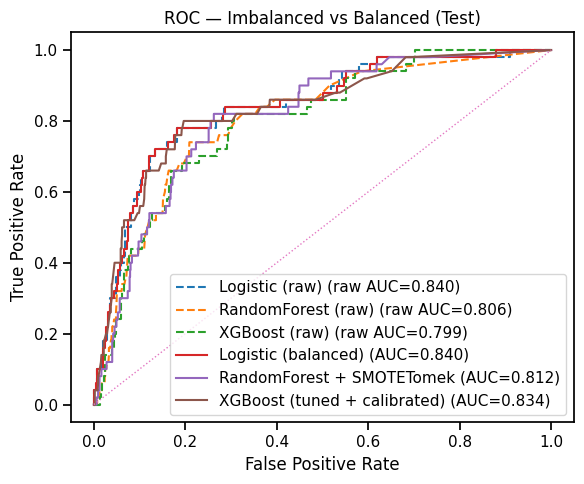

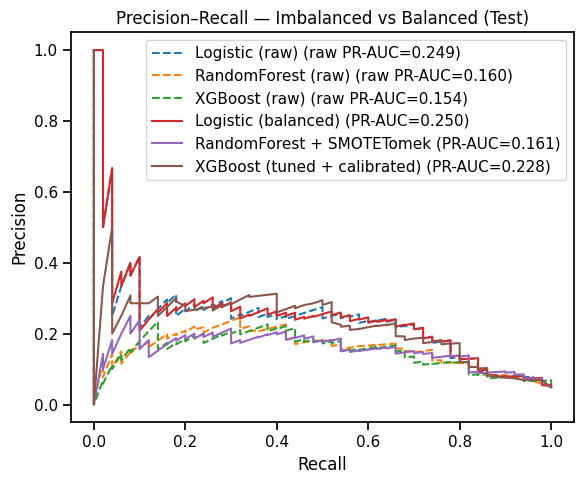

In [5]:
# === Overlay balanced models on ROC ===
plt.figure(figsize=(6,5))
# imbalanced
for c in curves_raw:
    plt.plot(c["fpr"], c["tpr"], linestyle="--", label=f'{c["name"]} (raw AUC={c["roc"]:.3f})')
# balanced
for r in [res_logit, res_rf, res_xgb]:
    plt.plot(r["fpr"], r["tpr"], label=f'{r["name"]} (AUC={r["roc"]:.3f})')
plt.plot([0,1],[0,1],':', linewidth=1)
plt.title("ROC — Imbalanced vs Balanced (Test)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout(); plt.show()

# === Overlay balanced models on PR ===
plt.figure(figsize=(6,5))
# imbalanced
for c in curves_raw:
    plt.plot(c["rec"], c["prec"], linestyle="--", label=f'{c["name"]} (raw PR-AUC={c["pr_auc"]:.3f})')
# balanced
for r in [res_logit, res_rf, res_xgb]:
    plt.plot(r["rec"], r["prec"], label=f'{r["name"]} (PR-AUC={r["pr"]:.3f})')
plt.title("Precision–Recall — Imbalanced vs Balanced (Test)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.tight_layout(); plt.show()
